In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision.ops
from torch import nn


class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False):
        super(DeformableConv2d, self).__init__()

        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        self.dilation = dilation

        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     dilation=self.dilation,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels,
                                        1 * kernel_size[0] * kernel_size[1],
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=self.padding,
                                        dilation=self.dilation,
                                        bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      dilation=self.dilation,
                                      bias=bias)

    def forward(self, x):
        # h, w = x.shape[2:]
        # max_offset = max(h, w)/4.

        offset = self.offset_conv(x)  # .clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        # op = (n - (k * d - 1) + 2p / s)
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          dilation=self.dilation)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Paper_model(nn.Module):
    def __init__(self,classes=8, conv_num=32):
        super(Paper_model, self).__init__()
        bn_axis = 1  # assuming channels first
        self.conv_num = conv_num

        self.conv_1_offset = DeformableConv2d(1,conv_num)
        self.conv_1 = nn.Conv2d(conv_num, conv_num, kernel_size=3, stride=2, padding=1)
        self.batch_normalization_1 = nn.BatchNorm2d(conv_num)

        self.conv_2_offset = DeformableConv2d(conv_num,conv_num*2)
        self.conv_2 = nn.Conv2d(conv_num * 2 , conv_num * 2, kernel_size=3, stride=2, padding=1)
        self.batch_normalization_2 = nn.BatchNorm2d(conv_num * 2)

        self.conv_3_offset = DeformableConv2d(conv_num * 2,conv_num * 4)
        self.conv_3 = nn.Conv2d(conv_num * 4, conv_num * 4, kernel_size=3, stride=2, padding=1)
        self.batch_normalization_3 = nn.BatchNorm2d(conv_num * 4)

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

        # self.fc = nn.Linear(conv_num * 4, classes)

    def forward(self, x):
        x = self.conv_1_offset(x)
        x = self.conv_1(x)
        x = self.batch_normalization_1(x)
        x = F.gelu(x)

        x = self.conv_2_offset(x)
        x = self.conv_2(x)
        x = self.batch_normalization_2(x)
        x = F.gelu(x)

        x = self.conv_3_offset(x)
        x = self.conv_3(x)
        x = self.batch_normalization_3(x)
        x = F.gelu(x)

        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        # x = self.fc(x)
        return x


In [ ]:
you = DeformableConv2d(1,50)
print(you.forward(torch.randn(1,1,52,52)).shape)
x = torch.randn(10,1,52,52)
print(type(x))
test = Paper_model()
result = test.forward(x)
print(result.shape)
print(result)

x2 = torch.randn(10,1,52,52)
result2 = test.forward(x2)
out = torch.cat((result, result2), dim=1)
out.shape

torch.Size([1, 50, 52, 52])
<class 'torch.Tensor'>
torch.Size([10, 128])
tensor([[0.2286, 0.1921, 0.2469,  ..., 0.3494, 0.2060, 0.2610],
        [0.4301, 0.1470, 0.1975,  ..., 0.3792, 0.2677, 0.3128],
        [0.1658, 0.3483, 0.3068,  ..., 0.2606, 0.3178, 0.2691],
        ...,
        [0.3111, 0.3142, 0.2903,  ..., 0.2688, 0.1338, 0.1871],
        [0.3420, 0.2714, 0.2171,  ..., 0.1841, 0.2882, 0.3129],
        [0.1968, 0.2082, 0.2087,  ..., 0.2826, 0.2602, 0.3490]],
       grad_fn=<ViewBackward0>)


torch.Size([10, 256])

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, model1, model2, classes=8, hidden_size=128):
        super(CombinedModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.linear = nn.Linear(hidden_size * 2, classes)

    def forward(self, x1, x2):
        out1 = self.model1(x1)
        out2 = self.model2(x2)
        combined_output = torch.cat((out1, out2), dim=1)
        output = self.linear(combined_output)
        return torch.sigmoid(output)

In [ ]:
model1 = Paper_model()
model2 = Paper_model()
combined_model = CombinedModel(model1, model2)

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

class WaferDataset(Dataset):
    def __init__(self, img_array_ori, img_array, label_array):
        self.img_array_ori = img_array_ori
        self.img_array = img_array
        self.label_array = label_array


    def __len__(self):
        return len(self.label_array)

    def __getitem__(self, idx):
        img_ori = torch.from_numpy(self.img_array_ori[idx]).float().unsqueeze(0)
        img = torch.from_numpy(self.img_array[idx]).float().unsqueeze(0)  # 转换为 PyTorch 张量
        label = torch.from_numpy(self.label_array[idx]).float()  # 转换为 PyTorch 张量
        return img_ori, img, label

# 加载数据
data_ori = np.load('/content/drive/MyDrive/DeepLearning_project/Dataset/Wafer_Map_Datasets.npz')
img_array_ori = data_ori['arr_0']
label_array_ori = data_ori['arr_1']
data = np.load('/content/drive/MyDrive/DeepLearning_project/Dataset/Filter_dataset.npz') # V3_dataset.npz
img_array = data['arr_0']
label_array = data['arr_1']

if len(img_array_ori) != len(img_array):
    raise ValueError("The lengths of img_array_ori and img_array are not equal")
if len(label_array_ori) != len(label_array):
    raise ValueError("The lengths of label_array_ori and label_array are not equal")
# 创建数据集
wafer_dataset = WaferDataset(img_array_ori, img_array, label_array)

# 设置划分比例
val_split = 0.2
dataset_size = len(wafer_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
val_size = int(np.floor(val_split * dataset_size))
train_indices, val_indices = indices[val_size:], indices[:val_size]

# 创建训练集和验证集的 SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# 创建数据加载器
batch_size = 32
train_dataloader = DataLoader(wafer_dataset, batch_size=batch_size, sampler=train_sampler)
val_dataloader = DataLoader(wafer_dataset, batch_size=batch_size, sampler=val_sampler)

len(wafer_dataset)


38015

In [ ]:
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# from torch.utils.data.sampler import SubsetRandomSampler
#
#
# dataset = TensorDataset(torch.tensor(list(range(20))))  # 构造一个数据集（0到19）
# idx = list(range(len(dataset)))  # 创建索引，SubsetRandomSampler会自动乱序
# # idx = torch.zeros(len(dataset)).long()  # 传入相同的索引，SubsetRandomSampler只会采样相同结果
# print(idx)
# n = len(dataset)
# split = n//5
# train_sampler = SubsetRandomSampler(idx[split::])  # 随机取80%的数据做训练集
# test_sampler = SubsetRandomSampler(idx[::split])  # 随机取20%的数据做测试集
# train_loader = DataLoader(dataset, batch_size = 5, sampler=train_sampler)
# train_loader_2 = DataLoader(dataset, batch_size = 5, sampler=train_sampler)
# test_loader = DataLoader(dataset, batch_size = 5, sampler=test_sampler)
#
# print('data for training:')
# for i in train_loader:
#     print(i)
# print('data for training2:')
# for i in train_loader_2:
#     print(i)
#
# print('data for testing:')
# for i in test_loader:
#     print(i)

In [ ]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

best_acc = 0.9740

# 使用数据加载器进行训练
# 创建模型实例
# paper_model = Paper_model()

# 定义损失函数
criterion = nn.BCELoss()

# 定义优化器
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)  # 可以调整学习率


num_epochs = 30
# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 将模型移动到设备上
combined_model.to(device)


import random
from tqdm import tqdm
def caculate_acc_num(outputs,labels):
  acc_num = 0
  predicted = (outputs > 0.5).float()
  #print(outputs.shape)
  for idx in range(predicted.shape[0]):
    #print("Predicted : ",predicted[idx])
    #print("Labels : ",labels[idx])
    if torch.allclose(predicted[idx], labels[idx]):
      acc_num += 1

  return acc_num
# 使用数据加载器进行训练
for epoch in range(num_epochs):
    train_acc_num = 0
    total_train = 0
    train_loss = 0
    for imgs_ori, imgs, labels in tqdm(train_dataloader):
        # 清除梯度
        optimizer.zero_grad()
        imgs_ori = imgs_ori.to(device)
        imgs = imgs.to(device)
        labels = labels.to(device)
        # 前向传播
        outputs = combined_model(imgs_ori, imgs)
        total_train += imgs.shape[0]
        train_acc_num += caculate_acc_num(outputs,labels)
        # 计算损失
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        # 反向传播
        loss.backward()

        # 更新权重
        optimizer.step()
        # 随机选择一笔数据打印其标签和预测值
        #idx = random.randint(0, len(labels) - 1)
        #print(f'Label: {labels[idx]}, Prediction: {(outputs[idx] > 0.5).float()}')

    val_acc_num = 0
    total_val = 0
    val_loss = 0
    for imgs_ori, imgs, labels in tqdm(val_dataloader):
        # 前向传播
        imgs_ori = imgs_ori.to(device)
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = combined_model(imgs_ori, imgs)
        total_val += imgs.shape[0]
        val_acc_num += caculate_acc_num(outputs, labels)
        # 计算损失
        loss = criterion(outputs, labels)
        val_loss += loss.item()


    # 每个 epoch 结束后打印损失
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {(train_loss/total_train):.4f} , Acc : {(train_acc_num/total_train):.4f}')
    print(f'Val_loss: {(val_loss/total_val):.4f}, Val_Acc: {(val_acc_num/total_val):.4f}')

    if (val_acc_num/total_val) > best_acc :
      best_acc = (val_acc_num/total_val)
      torch.save(combined_model.state_dict(), f'/content/drive/MyDrive/DeepLearning_project/Pytorch_version_dfc/V5_weight/weight_{best_acc:.4f}.pth')

Using device: cuda


100%|██████████| 238/238 [00:03<00:00, 66.62it/s]


Epoch [1/30], Loss: 0.0003 , Acc : 0.9824
Val_loss: 0.0004, Val_Acc: 0.9750


100%|██████████| 238/238 [00:03<00:00, 78.93it/s]


Epoch [2/30], Loss: 0.0003 , Acc : 0.9833
Val_loss: 0.0005, Val_Acc: 0.9712


100%|██████████| 238/238 [00:03<00:00, 79.09it/s]


Epoch [3/30], Loss: 0.0003 , Acc : 0.9857
Val_loss: 0.0005, Val_Acc: 0.9719


100%|██████████| 238/238 [00:03<00:00, 66.74it/s]


Epoch [4/30], Loss: 0.0003 , Acc : 0.9840
Val_loss: 0.0005, Val_Acc: 0.9708


100%|██████████| 238/238 [00:03<00:00, 79.12it/s]


Epoch [5/30], Loss: 0.0003 , Acc : 0.9841
Val_loss: 0.0004, Val_Acc: 0.9730


100%|██████████| 238/238 [00:02<00:00, 79.55it/s]


Epoch [6/30], Loss: 0.0002 , Acc : 0.9880
Val_loss: 0.0005, Val_Acc: 0.9682


100%|██████████| 238/238 [00:03<00:00, 68.94it/s]


Epoch [7/30], Loss: 0.0002 , Acc : 0.9868
Val_loss: 0.0005, Val_Acc: 0.9729


100%|██████████| 238/238 [00:03<00:00, 77.70it/s]


Epoch [8/30], Loss: 0.0002 , Acc : 0.9856
Val_loss: 0.0005, Val_Acc: 0.9745


100%|██████████| 238/238 [00:03<00:00, 78.40it/s]


Epoch [9/30], Loss: 0.0002 , Acc : 0.9876
Val_loss: 0.0005, Val_Acc: 0.9728


100%|██████████| 238/238 [00:03<00:00, 70.97it/s]


Epoch [10/30], Loss: 0.0002 , Acc : 0.9867
Val_loss: 0.0006, Val_Acc: 0.9672


100%|██████████| 238/238 [00:03<00:00, 75.62it/s]


Epoch [11/30], Loss: 0.0002 , Acc : 0.9890
Val_loss: 0.0005, Val_Acc: 0.9769


100%|██████████| 238/238 [00:03<00:00, 78.04it/s]


Epoch [12/30], Loss: 0.0002 , Acc : 0.9891
Val_loss: 0.0005, Val_Acc: 0.9734


100%|██████████| 238/238 [00:03<00:00, 72.18it/s]


Epoch [13/30], Loss: 0.0002 , Acc : 0.9886
Val_loss: 0.0006, Val_Acc: 0.9732


100%|██████████| 238/238 [00:03<00:00, 63.46it/s]


Epoch [14/30], Loss: 0.0002 , Acc : 0.9877
Val_loss: 0.0005, Val_Acc: 0.9730


100%|██████████| 238/238 [00:03<00:00, 77.10it/s]


Epoch [15/30], Loss: 0.0002 , Acc : 0.9880
Val_loss: 0.0005, Val_Acc: 0.9715


100%|██████████| 238/238 [00:03<00:00, 76.41it/s]


Epoch [16/30], Loss: 0.0002 , Acc : 0.9879
Val_loss: 0.0006, Val_Acc: 0.9701


100%|██████████| 238/238 [00:03<00:00, 69.33it/s]


Epoch [17/30], Loss: 0.0002 , Acc : 0.9896
Val_loss: 0.0005, Val_Acc: 0.9744


100%|██████████| 238/238 [00:03<00:00, 74.55it/s]


Epoch [18/30], Loss: 0.0002 , Acc : 0.9876
Val_loss: 0.0005, Val_Acc: 0.9722


100%|██████████| 238/238 [00:02<00:00, 79.42it/s]


Epoch [19/30], Loss: 0.0002 , Acc : 0.9910
Val_loss: 0.0005, Val_Acc: 0.9734


100%|██████████| 238/238 [00:03<00:00, 73.33it/s]


Epoch [20/30], Loss: 0.0002 , Acc : 0.9904
Val_loss: 0.0006, Val_Acc: 0.9741


100%|██████████| 238/238 [00:03<00:00, 75.90it/s]


Epoch [21/30], Loss: 0.0001 , Acc : 0.9908
Val_loss: 0.0005, Val_Acc: 0.9762


100%|██████████| 238/238 [00:03<00:00, 74.51it/s]


Epoch [22/30], Loss: 0.0002 , Acc : 0.9891
Val_loss: 0.0006, Val_Acc: 0.9705


100%|██████████| 238/238 [00:03<00:00, 61.12it/s]


Epoch [23/30], Loss: 0.0001 , Acc : 0.9914
Val_loss: 0.0005, Val_Acc: 0.9749


100%|██████████| 238/238 [00:03<00:00, 72.60it/s]


Epoch [24/30], Loss: 0.0002 , Acc : 0.9904
Val_loss: 0.0005, Val_Acc: 0.9744


100%|██████████| 238/238 [00:03<00:00, 79.33it/s]


Epoch [25/30], Loss: 0.0002 , Acc : 0.9897
Val_loss: 0.0005, Val_Acc: 0.9745


100%|██████████| 238/238 [00:03<00:00, 64.46it/s]


Epoch [26/30], Loss: 0.0002 , Acc : 0.9905
Val_loss: 0.0005, Val_Acc: 0.9761


100%|██████████| 238/238 [00:02<00:00, 79.51it/s]


Epoch [27/30], Loss: 0.0001 , Acc : 0.9922
Val_loss: 0.0005, Val_Acc: 0.9775


100%|██████████| 238/238 [00:03<00:00, 78.41it/s]


Epoch [28/30], Loss: 0.0002 , Acc : 0.9906
Val_loss: 0.0006, Val_Acc: 0.9715


100%|██████████| 238/238 [00:03<00:00, 61.74it/s]


Epoch [29/30], Loss: 0.0001 , Acc : 0.9920
Val_loss: 0.0006, Val_Acc: 0.9753


100%|██████████| 238/238 [00:04<00:00, 53.31it/s]

Epoch [30/30], Loss: 0.0001 , Acc : 0.9916
Val_loss: 0.0006, Val_Acc: 0.9745


In [ ]:
combined_model = CombinedModel(model1, model2)  # create an instance of the model
combined_model.load_state_dict(torch.load(f'/content/drive/MyDrive/DeepLearning_project/Pytorch_version_dfc/V5_weight/weight_0.9775.pth'))
combined_model.eval()

CombinedModel(
  (model1): Paper_model(
    (conv_1_offset): DeformableConv2d(
      (offset_conv): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (modulator_conv): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (regular_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (conv_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_normalization_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_2_offset): DeformableConv2d(
      (offset_conv): Conv2d(32, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (modulator_conv): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (regular_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_normalization_2): BatchNorm2d(64, eps=1e-

In [ ]:
!pip install thop
from thop import profile  # Import the profiler
import torch.optim as optim
from tqdm import tqdm

# Define the loss function
criterion = nn.BCELoss()
# Define the optimizer
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)  # Adjustable learning rate

def calculate_acc_num(outputs, labels):
    acc_num = 0
    predicted = (outputs > 0.5).float()
    for idx in range(predicted.shape[0]):
        if torch.allclose(predicted[idx], labels[idx]):
            acc_num += 1
    return acc_num

def evaluate_model(model, dataloader, device):
    model.to(device)
    model.eval()
    val_acc_num = 0
    total_val = 0
    val_loss = 0
    # Assume the first batch to infer the input size for FLOPs calculation
    first_batch = next(iter(dataloader))
    imgs_ori, imgs, _ = first_batch
    input_shape = imgs_ori.shape  # Assuming imgs_ori to be representative

    # Calculate FLOPs and Parameters
    flops, params = profile(model, inputs=(imgs_ori.to(device), imgs.to(device)), verbose=False)

    # Convert FLOPs to GigaFLOPs and parameters to thousands (K)
    flops_in_gflops = flops / 1e9  # Convert from FLOPs to GFLOPs
    params_in_k = params / 1e3     # Convert from parameters to thousands

    # Print the results formatted as GFLOPs and K
    print(f"FLOPs: {flops_in_gflops:.4f} GFLOPs   Params: {params_in_k:.3f}K")

    for imgs_ori, imgs, labels in tqdm(dataloader):
        imgs_ori = imgs_ori.to(device)
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs_ori, imgs)
        total_val += imgs.shape[0]
        val_acc_num += calculate_acc_num(outputs, labels)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

    print(f'Val_loss: {val_loss / total_val:.4f}, Val_Acc: {val_acc_num / total_val:.4f}')
    return outputs

outputs = evaluate_model(combined_model, val_dataloader, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

100%|██████████| 238/238 [00:03<00:00, 64.96it/s]

Val_loss: 0.0004, Val_Acc: 0.9794


37


100%|██████████| 238/238 [00:02<00:00, 91.01it/s] 


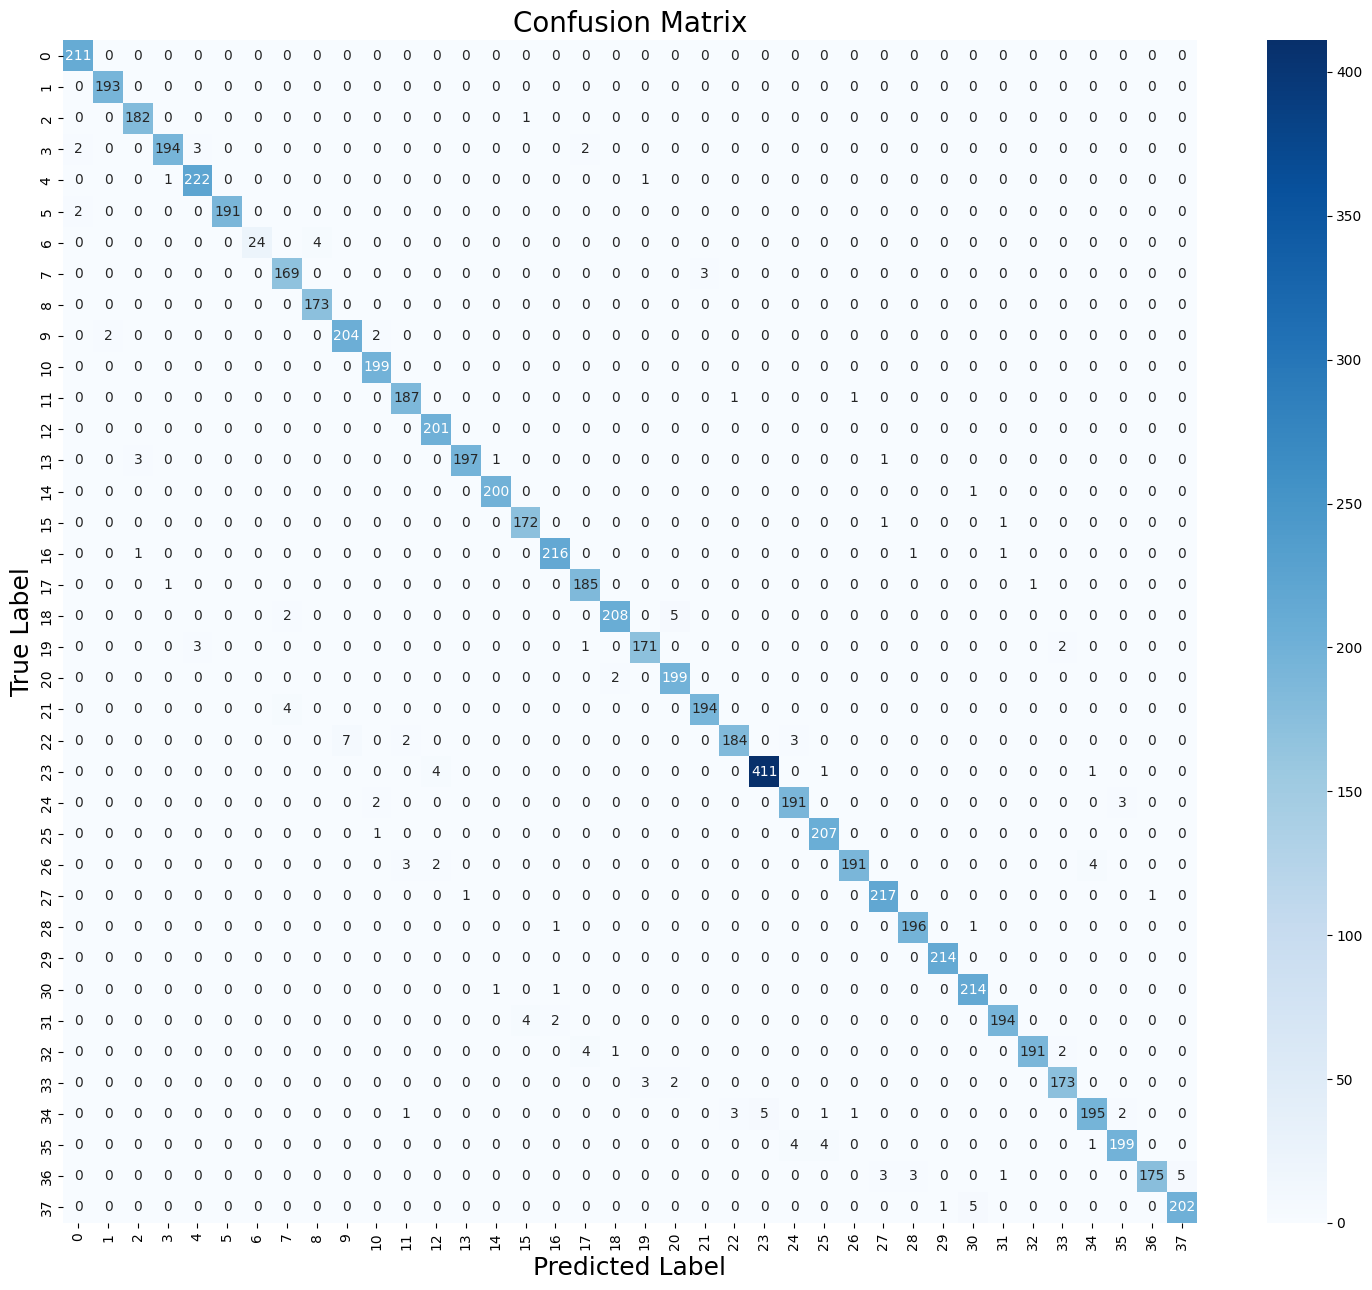

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       211
           1       0.99      1.00      0.99       193
           2       0.98      0.99      0.99       183
           3       0.99      0.97      0.98       201
           4       0.97      0.99      0.98       225
           5       1.00      0.99      0.99       193
           6       1.00      0.83      0.91        29
           7       0.97      0.98      0.97       172
           8       0.98      1.00      0.99       173
           9       0.97      0.98      0.97       208
          10       0.98      1.00      0.99       199
          11       0.97      0.99      0.98       189
          12       0.97      1.00      0.99       201
          13       0.99      0.98      0.98       202
          14       0.99      1.00      0.99       201
          15       0.97      0.99      0.98       174
          16       0.98      0.99      0.98       219
          17       0.96    

In [ ]:
CLASS_MAPPING = {
    "[0 0 0 0 0 0 0 0]":0,
    "[1 0 0 0 0 0 0 0]":1,
    "[0 1 0 0 0 0 0 0]":2,
    "[0 0 1 0 0 0 0 0]":3,
    "[0 0 0 1 0 0 0 0]":4,
    "[0 0 0 0 1 0 0 0]":5,
    "[0 0 0 0 0 1 0 0]":6,
    "[0 0 0 0 0 0 1 0]":7,
    "[0 0 0 0 0 0 0 1]":8,
    "[1 0 1 0 0 0 0 0]":9,
    "[1 0 0 1 0 0 0 0]":10,
    "[1 0 0 0 1 0 0 0]":11,
    "[1 0 0 0 0 0 1 0]":12,
    "[0 1 1 0 0 0 0 0]":13,
    "[0 1 0 1 0 0 0 0]":14,
    "[0 1 0 0 1 0 0 0]":15,
    "[0 1 0 0 0 0 1 0]":16,
    "[0 0 1 0 1 0 0 0]":17,
    "[0 0 1 0 0 0 1 0]":18,
    "[0 0 0 1 1 0 0 0]":19,
    "[0 0 0 1 0 0 1 0]":20,
    "[0 0 0 0 1 0 1 0]":21,
    "[1 0 1 0 1 0 0 0]":22,
    "[1 0 1 0 0 0 1 0]":23,
    "[1 0 0 1 1 0 0 0]":24,
    "[1 0 0 1 0 0 1 0]":25,
    "[1 0 0 0 1 0 1 0]":26,
    "[0 1 1 0 1 0 0 0]":27,
    "[0 1 1 0 0 0 1 0]":28,
    "[0 1 0 1 1 0 0 0]":29,
    "[0 1 0 1 0 0 1 0]":30,
    "[0 1 0 0 1 0 1 0]":31,
    "[0 0 1 0 1 0 1 0]":32,
    "[0 0 0 1 1 0 1 0]":33,
    "[1 0 1 0 1 0 1 0]":34,
    "[1 0 0 1 1 0 1 0]":35,
    "[0 1 1 0 1 0 1 0]":36,
    "[0 1 0 1 1 0 1 0]":37
}

#%%
key = "[0 1 0 1 1 0 1 0]"
value = CLASS_MAPPING["[0 1 0 1 1 0 1 0]"]
print(value)
#%%
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_confusion_matrix_and_accuracy(model, dataloader, device, class_mapping):
    num_classes = len(class_mapping)
    class_labels = [None] * num_classes
    for label_str, index in class_mapping.items():
        class_labels[index] = str(index)  # Directly use the numerical identifier

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for imgs_ori, imgs, labels in tqdm(dataloader):
            imgs_ori = imgs_ori.to(device)
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs_ori, imgs)
            predicted = (outputs > 0.5).float()

            for i in range(labels.size(0)):
                label_vec = labels[i].to(torch.uint8).tolist()
                label_str = '[' + ' '.join(map(str, label_vec)) + ']'
                class_idx = class_mapping[label_str]

                pred_vec = predicted[i].tolist()
                pred_str = '[' + ' '.join(str(int(p)) for p in pred_vec) + ']'
                pred_idx = class_mapping.get(pred_str, -1)  # Handle unseen/misformatted predictions

                all_labels.append(class_idx)
                all_predictions.append(pred_idx)

    # Compute the confusion matrix
    conf_mat = confusion_matrix(all_labels, all_predictions, labels=range(len(class_mapping)))

    # Plotting the confusion matrix
    plt.figure(figsize=(15, 13))  # Increase figure size
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix', size=20)  # Increase title font size
    plt.ylabel('True Label', size=18)  # Increase y-axis label font size
    plt.xlabel('Predicted Label', size=18)  # Increase x-axis label font size

    # Improve layout to prevent cut-off issues
    plt.xticks(rotation=90, size=10)  # Rotate x labels for better fit, adjust size as needed
    plt.yticks(size=10)  # Adjust y labels size as needed
    plt.tight_layout()  # This adjusts subplot params so that the subplot(s) fits in to the figure area

    plt.show()

    # Printing classification report
    print(classification_report(
        all_labels,
        all_predictions,
        target_names=class_labels,
        labels=range(len(class_labels))  # Ensure it considers all classes
    ))

    # Calculate and print class-specific accuracy
    class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(axis=1)
    for i, accuracy in enumerate(class_accuracy):
        if not np.isnan(accuracy):
            print(f'Accuracy of class {class_labels[i]} : {accuracy:.2f}%')
        else:
            print(f'No samples for class {class_labels[i]}')

# Call the function
plot_confusion_matrix_and_accuracy(combined_model, val_dataloader, device, CLASS_MAPPING)